In [1]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pwd

'/Users/millicentomondi/Documents/Cassava'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# reading lime_image
from lime import lime_image
from skimage.segmentation import mark_boundaries 

In [4]:
# Define paths
data_dir = '/Users/millicentomondi/Documents/Cassava/cassava_leaves'
train_dir = '/Users/millicentomondi/Documents/Cassava/train'
val_dir = '/Users/millicentomondi/Documents/Cassava/val'

# # Create train and validation directories (comment after splitting your dataset)
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Get the list of classes (subfolders in the data_dir)
# classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# for cls in classes:
#     # Create class subdirectories in train and validation directories
#     os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
#     os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

#     # Get the list of image files for the current class
#     cls_dir = os.path.join(data_dir, cls)
#     images = [f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))]

#     # Check if there are images to split
#     if len(images) == 0:
#         print(f"No images found for class {cls}. Skipping...")
#         continue

#     # Split the images into train and validation sets
#     train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

#     # Move images to the respective directories
#     for img in train_images:
#         shutil.move(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
#     for img in val_images:
#         shutil.move(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))

# print("Dataset split into train and validation folders successfully.")


In [5]:
print(data_dir)

/Users/millicentomondi/Documents/Cassava/cassava_leaves


In [6]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [7]:
# Define the data directory
data_dir = '/Users/millicentomondi/Documents/Cassava'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}


In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 4522, 'val': 1134}


['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

# Define the model

In [22]:
model = models.inception_v3(pretrained=True)
# Modify the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99)  # Use all parameters


# Move the model to the GPU if available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model = model.to(device)

# Training the model

In [23]:
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs, aux_outputs = outputs
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss += 0.4 * criterion(aux_outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.float() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")


train Loss: 2.7645 Acc: 0.5312
val Loss: 0.9348 Acc: 0.6561
train Loss: 1.2036 Acc: 0.7021
val Loss: 0.7428 Acc: 0.7540
train Loss: 0.9143 Acc: 0.7691
val Loss: 0.6194 Acc: 0.7954
train Loss: 0.7206 Acc: 0.8204
val Loss: 0.5528 Acc: 0.8131
train Loss: 0.6834 Acc: 0.8286
val Loss: 0.5098 Acc: 0.8413
train Loss: 0.6009 Acc: 0.8549
val Loss: 0.5140 Acc: 0.8377
train Loss: 0.5611 Acc: 0.8591
val Loss: 0.5025 Acc: 0.8351
train Loss: 0.5117 Acc: 0.8737
val Loss: 0.4836 Acc: 0.8466
train Loss: 0.4800 Acc: 0.8815
val Loss: 0.4651 Acc: 0.8510
train Loss: 0.4196 Acc: 0.8965
val Loss: 0.4713 Acc: 0.8510
train Loss: 0.4467 Acc: 0.8901
val Loss: 0.4890 Acc: 0.8519
train Loss: 0.3915 Acc: 0.9078
val Loss: 0.4660 Acc: 0.8536
train Loss: 0.3911 Acc: 0.9000
val Loss: 0.5348 Acc: 0.8413
train Loss: 0.3392 Acc: 0.9173
val Loss: 0.5377 Acc: 0.8430
train Loss: 0.3324 Acc: 0.9219
val Loss: 0.5179 Acc: 0.8492
train Loss: 0.3300 Acc: 0.9169
val Loss: 0.5514 Acc: 0.8466
train Loss: 0.3114 Acc: 0.9259
val Loss:

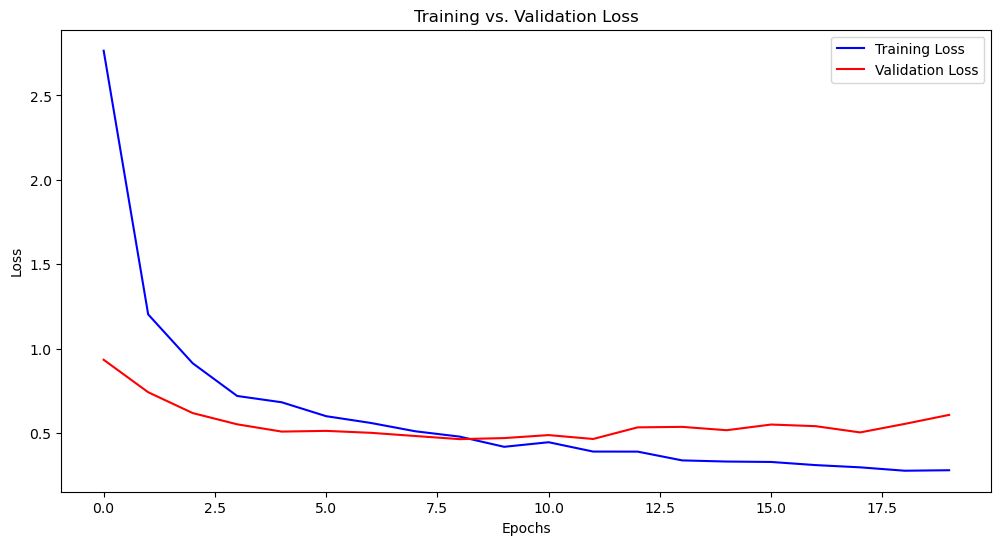

In [24]:
# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss',color='blue')
plt.plot(val_losses, label='Validation Loss',color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()




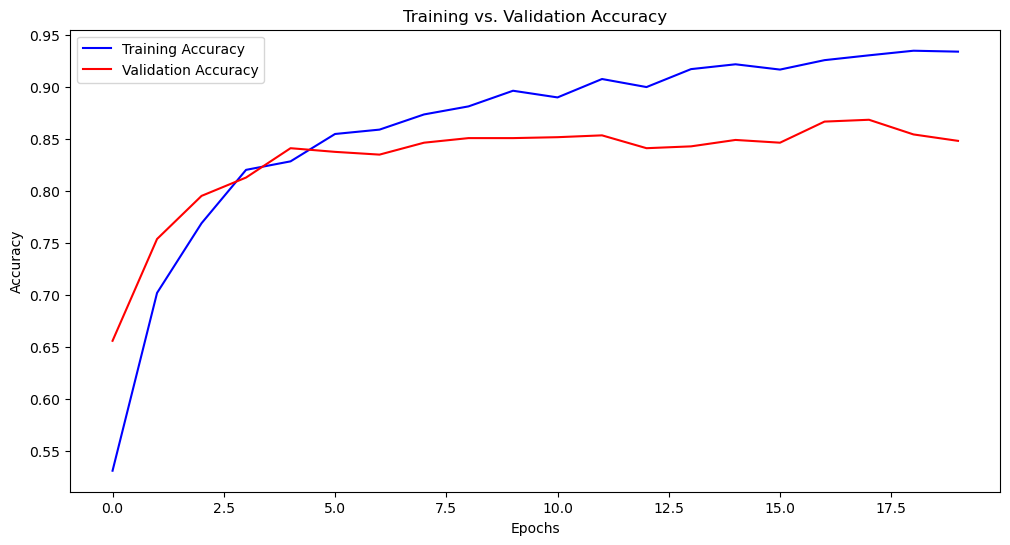

In [25]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy',color = 'blue')
plt.plot(val_accuracies, label='Validation Accuracy',color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

## Saving the model

In [26]:

# Save the model
torch.save(model.state_dict(), 'InceptioN_cassava_classification_model.pth')


# Classification on Unseen Image

In [27]:
# Load the saved model
model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('InceptioN_cassava_classification_model.pth'))
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [29]:
# Load and preprocess the unseen image
image_path = '/Users/millicentomondi/Documents/Cassava/test/test-img-391.jpg' # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


## Inference Using the model

In [30]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['cbb',
 'cbsd',
 'cgm',
 'cmd',
 'healthy']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: healthy


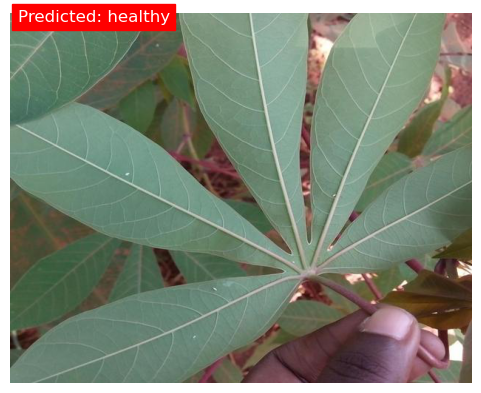

In [31]:
# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()